In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mn

%matplotlib inline


In [2]:
data = np.loadtxt('faithful.dat', skiprows=26, usecols=(1,2))

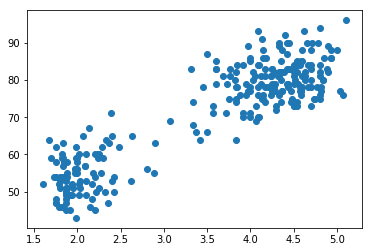

In [3]:
plt.scatter(data[:,0], data[:,1])

### Copied from lecture 11
The EM Algorithm (HTF 8.1) for a bimodal GMM is as follows (it looks pretty familiar):

Take initial guesses for $\hat{\mu}_1,\hat{\sigma}_2^2,\hat{\mu}_2,\hat{\sigma}_2^2,\hat{\pi}$

E-step: compute responsibilities 
$$
\hat{\gamma_i} = \frac{\hat{\pi}\phi_{\hat{\theta}_2}(y_i)}{(1-\hat{\pi}) \phi_{\hat{\theta}_1}(y_i) + \hat{\pi} \phi_{\hat{\theta}_2}(y_i)} \quad \text{for} \quad i=1,...,N
$$

M-step: compute weighted means and variances
\begin{align*}
\hat{\mu}_1 &= \frac{\sum_{i=1}^{N} (1-\hat{\gamma_i})y_i}{\sum_{i=1}^{N} (1-\hat{\gamma_i})}  \\
\hat{\sigma}_1^2 &= \frac{\sum_{i=1}^{N} (1-\hat{\gamma_i})(y_i-\hat{\mu}_1)^2}{\sum_{i=1}^{N} (1-\hat{\gamma}_i)}
\end{align*}
and similarly for $\hat{\mu}_2$, $\hat{\sigma}^2_2$ using $\hat{\gamma}_i$ in place of $(1-\hat{\gamma}_i)$.  The mixing probability is given by $\hat{\pi} = \sum_{i=1}^{N} \frac{\hat{\gamma_i}}{N}$.

Iterate steps 2 and 3 until convergence.

In [3]:
def dist(a, b):
    return np.linalg.norm(a - b)   

In [208]:
from numpy import random

def e_step(data,theta,sigma,pi):
    
    cluster_1 = (1-pi) * mn.pdf(data, mean = theta[0], cov = sigma[0])
    cluster_2 = pi * mn.pdf(data, mean = theta[1], cov = sigma[1])
    
    r = cluster_2 / ( cluster_1 + cluster_2)
    
    return r

def m_step(data, r):
    theta_1 = np.sum( (1 - r) * data.T, axis=1) / np.sum( 1- r)
    theta_2 = np.sum( r * data.T, axis=1) / np.sum(r)
    
    sigma_1 = ((data - theta_1) * (1 - r)[:,np.newaxis]).T.dot(data - theta_1) / np.sum(1 - r)
    sigma_2 = ((data - theta_2) * r[:,np.newaxis]).T.dot(data - theta_2) / np.sum(r)
    
    pi = np.sum(r)/len(r)
    
    return np.append(theta_1,theta_2).reshape((2,2)), np.append(sigma_1,sigma_2).reshape((2,2,2)), pi

def _is_converged(theta_his, sigma_his, pi_his, delta):
    theta_dist = dist(theta_his[-2],theta_his[-1])
    sigma_dist = dist(sigma_his[-2],sigma_his[-1])
    pi_dist = dist(pi_his[-2],pi_his[-1])
    return(theta_dist<delta and sigma_dist<delta and pi_dist<delta)



def GMM(data, loop=50, delta=0.0001):
    data = np.array(data)
    itr = 0
    #store value
    theta_history = []
    sigma_history = []
    pi_history = []
    
    #randomly generate initial values
    theta = np.zeros((2,2))
    theta[0] = data[random.randint(0,len(data))]
    theta[1] = data[random.randint(0,len(data))]
        
    sigma = np.zeros((2,2,2))
    sigma[0] = np.cov(data,rowvar=0)
    sigma[1] = np.copy(sigma[0])
        
    pi = 0.5
    
    
    theta_history.append(theta)
    sigma_history.append(sigma)
    pi_history.append(pi)
    
    for r in range(loop):
        r = e_step(data,theta,sigma,pi)
        theta,sigma,pi = m_step(data,r)
        theta_history.append(theta)
        sigma_history.append(sigma)
        pi_history.append(pi)
        itr +=1
        if _is_converged(theta_history,sigma_history,pi_history,delta):
            break
        
    return np.array(theta_history),np.array(sigma_history),np.array(pi_history), itr

In [209]:
G = GMM(data)
G[0]

array([[[ 4.        , 77.        ],
        [ 4.35      , 82.        ]],

       [[ 3.33717471, 68.7451047 ],
        [ 3.67540655, 73.57789955]],

       [[ 3.31471308, 68.4657788 ],
        [ 3.70343439, 73.92651911]],

       [[ 3.28336302, 68.07538436],
        [ 3.74269242, 74.4156524 ]],

       [[ 3.24305523, 67.57932582],
        [ 3.79332644, 75.03925691]],

       [[ 3.19079969, 66.95146399],
        [ 3.85920065, 75.83155415]],

       [[ 3.12138653, 66.14702633],
        [ 3.94679398, 76.84776055]],

       [[ 3.02639294, 65.10075068],
        [ 4.06470135, 78.14471246]],

       [[ 2.89414691, 63.73564316],
        [ 4.21176387, 79.63090546]],

       [[ 2.71849935, 61.95931198],
        [ 4.32168558, 80.58556385]],

       [[ 2.54037755, 60.08724571],
        [ 4.35446533, 80.78582637]],

       [[ 2.40176641, 58.60901147],
        [ 4.36307686, 80.8008213 ]],

       [[ 2.27938742, 57.23918925],
        [ 4.35698973, 80.72125063]],

       [[ 2.17624888, 56.03139773],
  

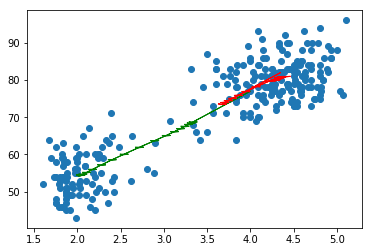

In [210]:
plt.scatter(data[:,0], data[:,1])
for i in range(len(G[0])-1):
    plt.arrow(G[0][i][0][0], G[0][i][0][1], G[0][i+1][0][0]-G[0][i][0][0], G[0][i+1][0][1]-G[0][i][0][1], head_width=0.1, head_length=0.2, color='g')
    plt.arrow(G[0][i][1][0], G[0][i][1][1], G[0][i+1][1][0]-G[0][i][1][0], G[0][i+1][1][1]-G[0][i][1][1], head_width=0.1, head_length=0.2, color='r')


In [218]:
iteration = []

for i in range(50):
    gmm = GMM(data)
    iteration.append(gmm[3])

(array([ 1.,  3., 20.,  4.,  7.,  2.,  3.,  0.,  4.,  6.]),
 array([ 2. ,  6.8, 11.6, 16.4, 21.2, 26. , 30.8, 35.6, 40.4, 45.2, 50. ]),
 <a list of 10 Patch objects>)

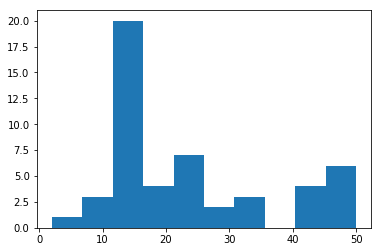

In [221]:
plt.hist(iteration)

In [80]:
from copy import deepcopy
def distance(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)


def KMeans(data, k):
    itr = 0
    
    #generate random centroids
    c_x = np.random.randint(0, np.max(data), size=k)
    c_y = np.random.randint(0, np.max(data), size=k)
    centroid = np.array(list(zip(c_x, c_y)), dtype=np.float32)
    print(centroid)

    c_his = np.zeros(centroid.shape) 
    clusters = np.zeros(len(data))
    err = distance(centroid, c_his, None)
    while err != 0:
        for i in range(len(data)):
            dis = distance(data[i], centroid)
            #print(dis)
            cluster = np.argmin(dis)
            #print(cluster)
            clusters[i] = cluster
            #print(clusters[i])
        c_his = deepcopy(centroid)
        for i in range(k):
            points = [data[j] for j in range(len(data)) if clusters[j] == i]
            a = np.mean(points, axis=0)
            #print(a)
            if a[0] == data[:,0].mean():
                centroid[i] = centroid[i]
            else:
                centroid[i] = a
                
        err = distance(centroid, c_his, None)
        itr +=1
        
    colors = ['red', 'green', 'blue', 'yellow']
    fig, ax = plt.subplots()
    for i in range(k):
        points = np.array([data[j] for j in range(len(data)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=colors[i])
    ax.scatter(centroid[:, 0], centroid[:, 1], marker='*', s=200, c='#050505')
    ax.legend()

    
    return centroid, itr
    

[[71.  0.]
 [86. 15.]]


6

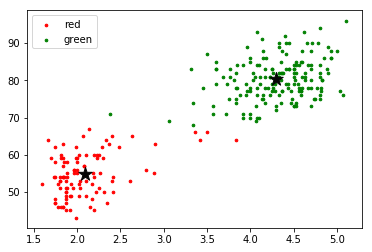

In [81]:
km = KMeans(data, 2)
km[1]

(array([ 0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.]),
 array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5]),
 <a list of 10 Patch objects>)

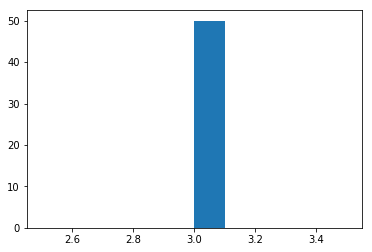

In [84]:
from sklearn.cluster import KMeans as KM
iteration_kmeans = []

for i in range(50):
    kmeans = KM(n_clusters=2, random_state=0).fit(data)
    #print(kmeans[1])
    iteration_kmeans.append(kmeans.n_iter_)

plt.hist(iteration_kmeans)